In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
import re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
path = "/content/drive/MyDrive/All.csv"
df = pd.read_csv(path)

### Get a brief look of the dataset

In [7]:
df.head(5)

,textual data,label,time
0,The directors herein present their report and ...,F,20001207
1,Entering the 21st century China has been well...,F,20010330
2,For the six months ended December 31 2000 th...,F,20010423
3,During the period under review the Group cont...,F,20010913
4,Business ReviewInstant Noodle BusinessAccumula...,F,20011115


In [8]:
#get dummy of label
#replace 'F' with 0, 'NF' with 1
df['label'].replace(['F','NF'], [0, 1], inplace=True)

### Spliting dataset

In [9]:
#remove stop words
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop = stopwords.words('english')
df['textual data'] = df['textual data'].fillna("")
df['textual data'] = df['textual data'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# train test split (whole dataset)
training_data = df.sample(frac = 0.8, random_state = 42)
testing_data = df.drop(training_data.index)
print("Number of training data: ", training_data.shape[0])
print("Number of test data: ", testing_data.shape[0])

Number of training data:  27878
Number of test data:  6970


In [11]:
# get the cleaning train test textual data and label
training_text = training_data['textual data']
training_text.str.lower()
training_label = np.array(training_data['label'])

test_text = testing_data['textual data']
test_text.str.lower()
test_label = np.array(testing_data['label'])

In [12]:
vocab_size = 10000
max_length = 120
trunc_type = 'post'
oov_tok = "<OOV>"

# generate the word index dictionary from the training sentences only
# then generate and pad both the training sequences and the test sequences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(training_text)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_text)
training_padded = pad_sequences(training_sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

### 1. Simple model with embedding layer

In [13]:
# 32 in the Embedding constructor means each word will be represented as a 32-element vector
model = Sequential([layers.Embedding(vocab_size, 32, input_length=max_length),
                    # insert layer for model building
                    layers.Flatten(),
                    layers.Dense(6, activation='relu'),
                    layers.Dense(1, activation='sigmoid')])

# setup the training parameters
# insert parameter values for .compile(), e.g. loss function & optimizer
# set the metrics parameter to be 'accuracy'
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])

# print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 32)           320000    
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 6)                 23046     
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 343,053
Trainable params: 343,053
Non-trainable params: 0
_________________________________________________________________


In [14]:
embeddingmodel_output = model.fit(training_padded, training_label, epochs = 10, validation_data=(testing_padded, test_label))

Epoch 1/10
872/872 [==============================] - 6s 4ms/step - loss: 0.0538 - accuracy: 0.9934 - val_loss: 0.0345 - val_accuracy: 0.9940
Epoch 2/10
872/872 [==============================] - 3s 4ms/step - loss: 0.0142 - accuracy: 0.9957 - val_loss: 0.0426 - val_accuracy: 0.9940
Epoch 3/10
872/872 [==============================] - 3s 4ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0643 - val_accuracy: 0.9940
Epoch 4/10
872/872 [==============================] - 4s 5ms/step - loss: 3.6397e-04 - accuracy: 0.9999 - val_loss: 0.0732 - val_accuracy: 0.9940
Epoch 5/10
872/872 [==============================] - 3s 4ms/step - loss: 9.8773e-05 - accuracy: 1.0000 - val_loss: 0.0764 - val_accuracy: 0.9940
Epoch 6/10
872/872 [==============================] - 3s 4ms/step - loss: 7.2155e-05 - accuracy: 1.0000 - val_loss: 0.0800 - val_accuracy: 0.9940
Epoch 7/10
872/872 [==============================] - 3s 4ms/step - loss: 6.1915e-05 - accuracy: 1.0000 - val_loss: 0.0836 - val_accurac

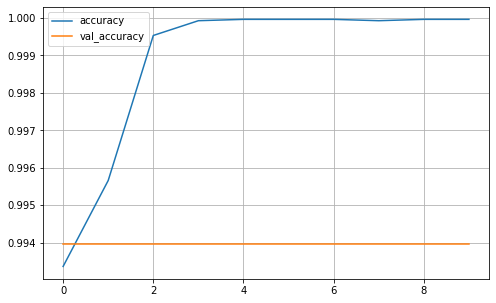

In [17]:
import matplotlib.pyplot as plt
metric_df = pd.DataFrame(embeddingmodel_output.history)
metric_df[['accuracy','val_accuracy']].plot(figsize = (8,5))
plt.grid(True)

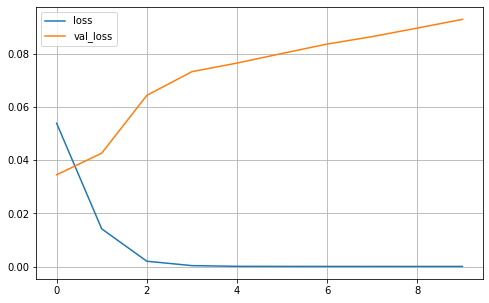

In [19]:
metric_df = pd.DataFrame(embeddingmodel_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 2. SimpleRNN model

In [26]:
# hyperparameters
embedding_dim = 100
state_dim = 64
dense_dim = 32

# model definition
model_vanillaRNN = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                            layers.Bidirectional(layers.SimpleRNN(state_dim)),
                            # only the output at the last step (the final hidden state) is fed into a fully-connected layer
                            layers.Dense(dense_dim, activation='relu'),
                            layers.Dense(1, activation='sigmoid')], name="vanilla")

# set the training parameters
model_vanillaRNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model_vanillaRNN.summary()

Model: "vanilla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 100)          1000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              21120     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,025,281
Trainable params: 1,025,281
Non-trainable params: 0
_________________________________________________________________


In [28]:
modelRNN_output = model_vanillaRNN.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
109/109 [==============================] - 25s 216ms/step - loss: 0.0620 - accuracy: 0.9895 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 2/10
109/109 [==============================] - 26s 235ms/step - loss: 0.0345 - accuracy: 0.9944 - val_loss: 0.0370 - val_accuracy: 0.9940
Epoch 3/10
109/109 [==============================] - 24s 216ms/step - loss: 0.0332 - accuracy: 0.9944 - val_loss: 0.0373 - val_accuracy: 0.9940
Epoch 4/10
109/109 [==============================] - 22s 205ms/step - loss: 0.0241 - accuracy: 0.9944 - val_loss: 0.0427 - val_accuracy: 0.9938
Epoch 5/10
109/109 [==============================] - 21s 197ms/step - loss: 0.0063 - accuracy: 0.9985 - val_loss: 0.0584 - val_accuracy: 0.9940
Epoch 6/10
109/109 [==============================] - 22s 200ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0632 - val_accuracy: 0.9940
Epoch 7/10
109/109 [==============================] - 23s 212ms/step - loss: 4.0390e-04 - accuracy: 1.0000 - val_loss: 0.0623 - va

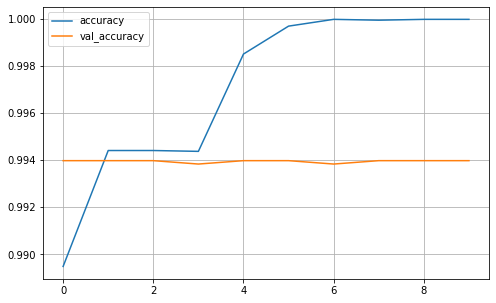

In [29]:
metric_df = pd.DataFrame(modelRNN_output.history)
metric_df[['accuracy','val_accuracy']].plot(figsize = (8,5))
plt.grid(True)

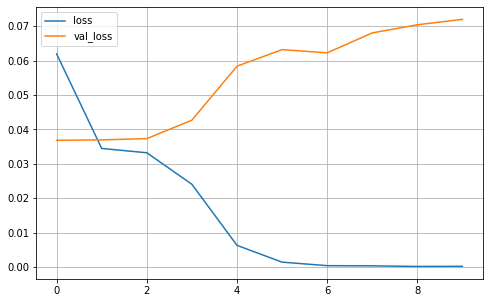

In [30]:
metric_df = pd.DataFrame(modelRNN_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 3. LSTM model

In [46]:
# hyperparameters
embedding_dim = 100
state_dim = 64
dense_dim = 32

# model definition
model_lstm = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                         layers.Bidirectional(layers.LSTM(state_dim)),
                         layers.Dense(dense_dim, activation='relu'),
                         layers.Dense(1, activation='sigmoid')], name="lstm")

# set the training parameters
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model_lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 120, 100)          1000000   
                                                                 
 bidirectional_8 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_18 (Dense)            (None, 32)                4128      
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 1,088,641
Trainable params: 1,088,641
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_lstm_output = model_lstm.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
109/109 [==============================] - 7s 28ms/step - loss: 0.1073 - accuracy: 0.9853 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 2/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0346 - accuracy: 0.9944 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 3/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0341 - accuracy: 0.9944 - val_loss: 0.0372 - val_accuracy: 0.9940
Epoch 4/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0323 - accuracy: 0.9944 - val_loss: 0.0378 - val_accuracy: 0.9940
Epoch 5/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0249 - accuracy: 0.9944 - val_loss: 0.0488 - val_accuracy: 0.9940
Epoch 6/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 7/10
109/109 [==============================] - 2s 20ms/step - loss: 0.0073 - accuracy: 0.9983 - val_loss: 0.0589 - val_accuracy: 0.9940

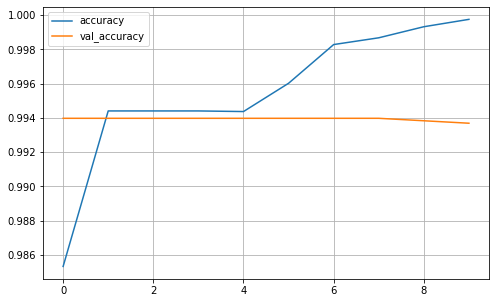

In [48]:
metric_df = pd.DataFrame(model_lstm_output.history)
metric_df[['accuracy','val_accuracy']].plot(figsize = (8,5))
plt.grid(True)

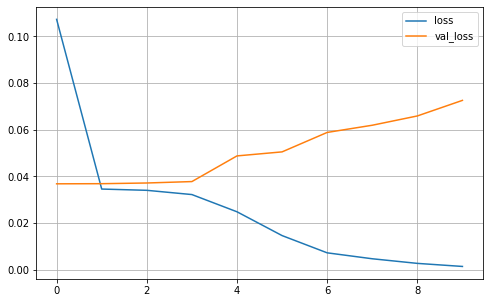

In [49]:
metric_df = pd.DataFrame(model_lstm_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 4. GRU Model

In [36]:
embedding_dim = 100
state_dim = 64
dense_dim = 32

# model definition
model_gru = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                         layers.Bidirectional(layers.GRU(state_dim)),
                         layers.Dense(dense_dim, activation='relu'),
                         layers.Dense(1, activation='sigmoid')], name="gru")

# set the training parameters
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model_gru.summary()

Model: "gru"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 100)          1000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              63744     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 32)                4128      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,067,905
Trainable params: 1,067,905
Non-trainable params: 0
_________________________________________________________________


In [37]:
model_gru_output = model_gru.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
109/109 [==============================] - 5s 25ms/step - loss: 0.1217 - accuracy: 0.9887 - val_loss: 0.0375 - val_accuracy: 0.9940
Epoch 2/10
109/109 [==============================] - 2s 18ms/step - loss: 0.0293 - accuracy: 0.9944 - val_loss: 0.0399 - val_accuracy: 0.9940
Epoch 3/10
109/109 [==============================] - 2s 18ms/step - loss: 0.0197 - accuracy: 0.9947 - val_loss: 0.0466 - val_accuracy: 0.9940
Epoch 4/10
109/109 [==============================] - 2s 18ms/step - loss: 0.0092 - accuracy: 0.9971 - val_loss: 0.0607 - val_accuracy: 0.9940
Epoch 5/10
109/109 [==============================] - 2s 18ms/step - loss: 0.0035 - accuracy: 0.9991 - val_loss: 0.0591 - val_accuracy: 0.9927
Epoch 6/10
109/109 [==============================] - 2s 18ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0830 - val_accuracy: 0.9937
Epoch 7/10
109/109 [==============================] - 2s 18ms/step - loss: 6.8549e-04 - accuracy: 0.9999 - val_loss: 0.0802 - val_accuracy: 0.

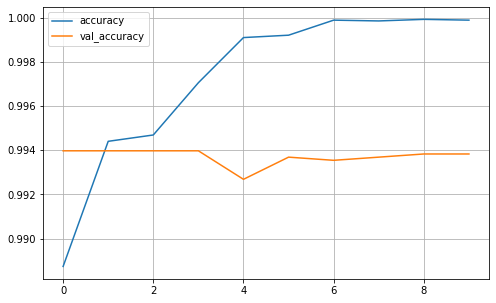

In [50]:
metric_df = pd.DataFrame(model_gru_output.history)
metric_df[['accuracy','val_accuracy']].plot(figsize = (8,5))
plt.grid(True)

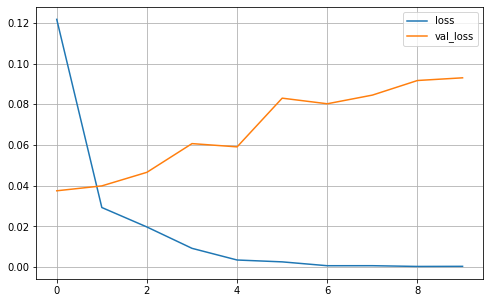

In [51]:
metric_df = pd.DataFrame(model_gru_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)

### 5. Multi-layer (LSTM) RNNs

In [52]:
embedding_dim = 100
state_dim = 64
dense_dim = 32


# model definition
model_multi_layer = Sequential([layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                                layers.Bidirectional(layers.LSTM(state_dim, return_sequences=True)),
                                layers.Bidirectional(layers.LSTM(state_dim, return_sequences=True)),
                                layers.Bidirectional(layers.LSTM(state_dim)),
                                layers.Dense(dense_dim, activation='relu'),
                                layers.Dense(1, activation='sigmoid')], name="multi_layer")

# set the training parameters
model_multi_layer.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print the model summary
model_multi_layer.summary()

Model: "multi_layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 120, 100)          1000000   
                                                                 
 bidirectional_9 (Bidirectio  (None, 120, 128)         84480     
 nal)                                                            
                                                                 
 bidirectional_10 (Bidirecti  (None, 120, 128)         98816     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 128)              98816     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 32)                4128      
                                                       

In [53]:
model_multilayer_output = model_multi_layer.fit(training_padded, training_label, batch_size=256, epochs=10, validation_data=(testing_padded, test_label))

Epoch 1/10
109/109 [==============================] - 16s 71ms/step - loss: 0.0814 - accuracy: 0.9857 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 2/10
109/109 [==============================] - 7s 61ms/step - loss: 0.0348 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 3/10
109/109 [==============================] - 6s 54ms/step - loss: 0.0349 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 4/10
109/109 [==============================] - 6s 54ms/step - loss: 0.0351 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 5/10
109/109 [==============================] - 6s 55ms/step - loss: 0.0349 - accuracy: 0.9944 - val_loss: 0.0369 - val_accuracy: 0.9940
Epoch 6/10
109/109 [==============================] - 6s 58ms/step - loss: 0.0348 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.9940
Epoch 7/10
109/109 [==============================] - 7s 61ms/step - loss: 0.0349 - accuracy: 0.9944 - val_loss: 0.0368 - val_accuracy: 0.994

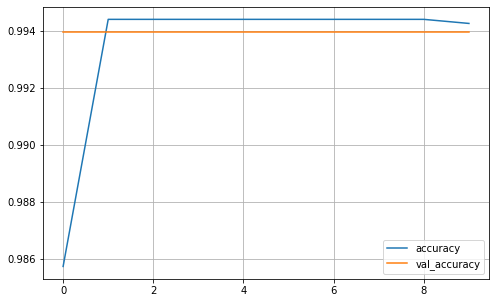

In [54]:
metric_df = pd.DataFrame(model_multilayer_output.history)
metric_df[['accuracy','val_accuracy']].plot(figsize = (8,5))
plt.grid(True)

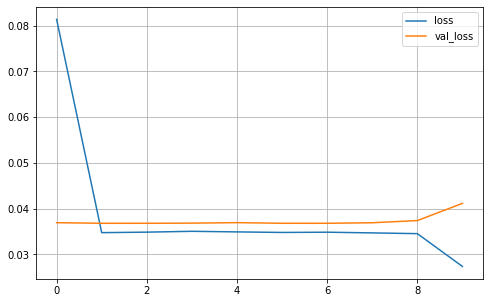

In [55]:
metric_df = pd.DataFrame(model_multilayer_output.history)
metric_df[['loss','val_loss']].plot(figsize = (8,5))
plt.grid(True)